In [1]:
import os
import time
import numpy as np
import pypulseq
import scipy.io as sio
from numpy import linalg as la

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages

from cest_mrf.write_scenario import write_yaml_2pool, write_yaml_dict
from cest_mrf.dictionary.generation import generate_mrf_cest_dictionary
from cest_mrf.metrics.dot_product import dot_prod_matching

import os
import sys

# Add the parent directory to sys.path to find the utils package
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.colormaps import b_viridis, b_winter  

from configs import ConfigPreclinical
from sequences import write_sequence_preclinical

# Specify data folder and output folder

In [2]:
data_f = 'data'
output_f = 'results'

# Write .yaml file and .seq file

In [3]:
cfg = ConfigPreclinical().get_config()

# Define output filenames
yaml_fn = cfg['yaml_fn']
seq_fn = cfg['seq_fn']
dict_fn = cfg['dict_fn']

# # Write the .yaml according to the config.py file (inside cest_mrf folder)
# write_yaml_2pool(cfg, yaml_fn)
write_yaml_dict(cfg, yaml_fn)

# Write the seq file for a 2d experiment
# for more info about the seq file, check out the pulseq-cest repository
seq_defs = {}
seq_defs['n_pulses'] = 1  # number of pulses
seq_defs['tp'] = 3  # pulse duration [s]
seq_defs['td'] = 0  # interpulse delay [s]
seq_defs['Trec'] = 1  # recovery time [s]
seq_defs['Trec_M0'] = 'NaN'  # recovery time with respect to m0 if exist [s]
seq_defs['M0_offset'] = 'NaN'  # dummy m0 offset [ppm]
seq_defs['DCsat'] = seq_defs['tp'] / (seq_defs['tp'] + seq_defs['td'])  # duty cycle
seq_defs['offsets_ppm'] = [3.0] * 30  # offset vector [ppm]
seq_defs['num_meas'] = len(seq_defs['offsets_ppm'])  # number of repetition
seq_defs['Tsat'] = seq_defs['n_pulses'] * (seq_defs['tp'] + seq_defs['td']) - seq_defs['td']
seq_defs['B0'] = cfg['b0']  # B0 [T]

seqid = os.path.splitext(seq_fn)[1][1:]
seq_defs['seq_id_string'] = seqid  # unique seq id

# Varied saturation pulse power (B1 (uT))
seq_defs['B1pa'] = [5, 5, 3, 3.75, 2.5, 1.75, 5.5, 6, 3.75,
                    5.75, 0.25, 3, 6, 4.5, 3.75, 3.5, 3.5, 0, 3.75, 6, 3.75, 4.75, 4.5,
                    4.25, 3.25, 5.25, 5.25, 0.25, 4.5, 5.25]

# Create .seq file
write_sequence_preclinical(seq_defs=seq_defs, seq_fn=seq_fn)

/home/paul/Documents/momentum_de/program/master/public_github/molecular-mrf/open-py-cest-mrf/cest_mrf/pypulseq/pypulseq/Sequence/write_seq.py:81: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  arb_grad_mask = grad_lib_values == 'g'
/home/paul/Documents/momentum_de/program/master/public_github/molecular-mrf/open-py-cest-mrf/cest_mrf/pypulseq/pypulseq/Sequence/write_seq.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  trap_grad_mask = grad_lib_values == 't'


# Generate the dictionary

In [4]:
start = time.perf_counter()
generate_mrf_cest_dictionary(seq_fn=seq_fn, param_fn=yaml_fn, dict_fn=dict_fn, num_workers=cfg['num_workers'],
                                axes='xy')  # axes can also be 'z' if no readout is simulated
end = time.perf_counter()
s = (end - start)
print(f"Dictionary simulation and preparation took {s:.03f} s.")


No MT pools found in param files! specify with "mt_pool"
Found 665873 different parameter combinations.
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
Future 14 is finished
Future 0 is finished
Future 4 is finished
Future 1 is finished
Future 9 is finished
Future 6 is fini

# Load scanned data and dot-product matching

In [5]:
acq_fn = 'acquired_data.mat'
acq_fn = os.path.join(data_f, acq_fn)

# Run dot product matching
start = time.perf_counter()
quant_maps = dot_prod_matching(dict_fn=dict_fn, acquired_data_fn=acq_fn)
end = time.perf_counter()
s = (end - start)
print(f"Dot product matching took {s:.03f} s.")

out_fn = 'quant_maps.mat'
out_fn = os.path.join(output_f, out_fn)
sio.savemat(out_fn, quant_maps)
print('quant_maps.mat saved')


Dot product matching took 16.395 s.
quant_maps.mat saved


In [6]:
out_fn = 'quant_maps.mat'
out_fn = os.path.join(output_f, out_fn)
quant_maps = sio.loadmat(out_fn)

In [7]:
# mask from dot-prod
mask = quant_maps['dp'] > 0.99974
np.save('mask.npy', mask)

# Print results

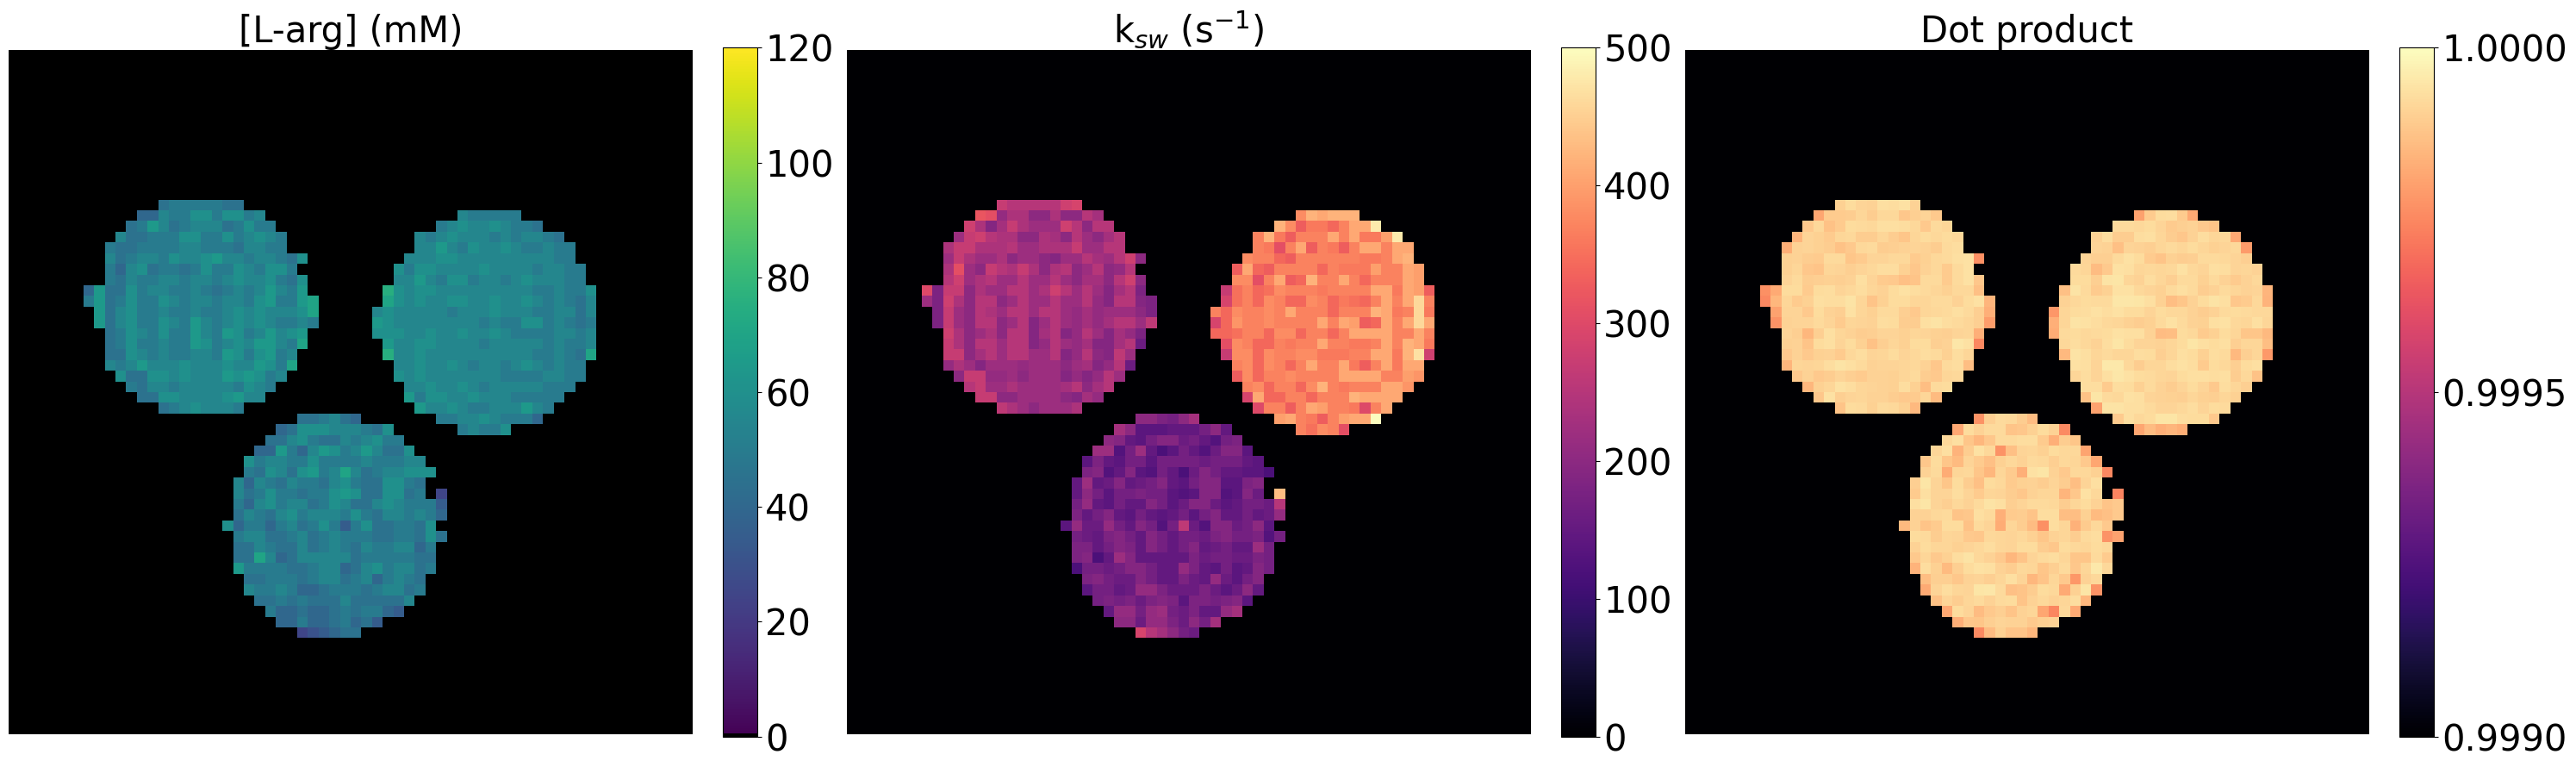

In [8]:
pdf_fn = 'dot_product_results.pdf' # quantitative maps output filename
pdf_fn = os.path.join(output_f, pdf_fn)

fig, axes = plt.subplots(1, 3, figsize=(30, 25))

color_maps = [b_viridis, 'magma', 'magma']
data_keys = ['fs', 'ksw', 'dp']
titles = ['[L-arg] (mM)', 'k$_{sw}$ (s$^{-1}$)', 'Dot product']
clim_list = [(0, 120), (0, 500), (0.999, 1)]
tick_list = [np.arange(0, 140, 20), np.arange(0, 600, 100), np.arange(0.999, 1.0005, 0.0005)]

unified_font_size = 30

# Save the plot to a PDF file
with PdfPages(pdf_fn) as pdf:
    for ax, color_map, key, title, clim, ticks in zip(axes.flat, color_maps, data_keys, titles, clim_list, tick_list):
        vals = quant_maps[key]

        if key == 'fs':
            vals = vals * 110e3/3

        plot = ax.imshow(vals * mask, cmap=color_map)
        plot.set_clim(*clim)
        ax.set_title(title, fontsize=unified_font_size)
        cb = plt.colorbar(plot, ax=ax, ticks=ticks, orientation='vertical', fraction=0.046, pad=0.04)
        cb.ax.tick_params(labelsize=unified_font_size)
        ax.set_axis_off()
    
    plt.tight_layout()
    pdf.savefig(fig)